<a href="https://colab.research.google.com/github/tanvirA25/Milestone-1/blob/milestone-2/ProjectCS301(Milestone2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone 2


In [1]:
# Setting up Environment 

In [2]:
!pip install patchify
!pip install keras
!pip install segmentation_models
!pip install tensorflow==2.7.0

import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2
import tensorflow as tf
import keras
from tensorflow import keras
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 21 kB/s 
Segmentation Models: using `keras` framework.


In [3]:
# Mounting the Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import glob as gb
from google.colab import drive
# below storing the dataset that we had from our drive into root_directory 
root_directory = '/content/drive/MyDrive/Semantic segmentation dataset'
patch_size = 256


In [6]:
# Patchifying image

image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_001.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_003.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_002.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_006.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_005.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_007.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_004.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_009.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/images/image_part_008.jpg
Now patchifying ima

In [7]:
#patchifying masks
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_002.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_003.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_009.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_004.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_001.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_005.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_008.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_007.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks/image_part_006.png
Now patchifying mask: /content/drive/

		Original Image 				Original Masks


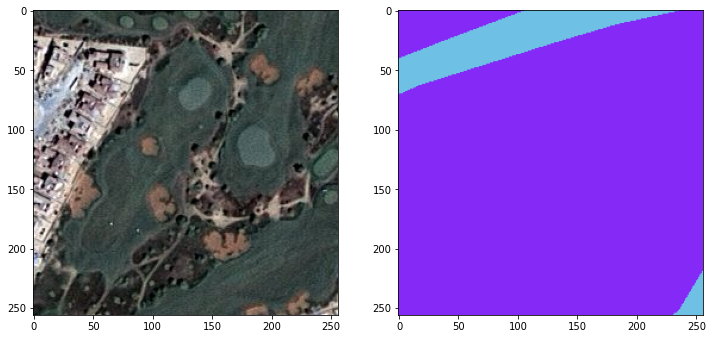

		Original Image 				Original Masks


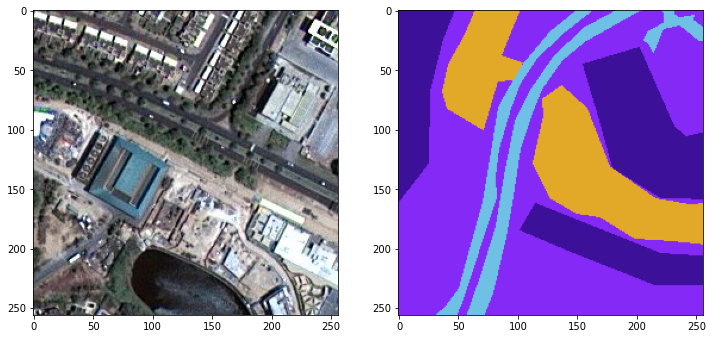

		Original Image 				Original Masks


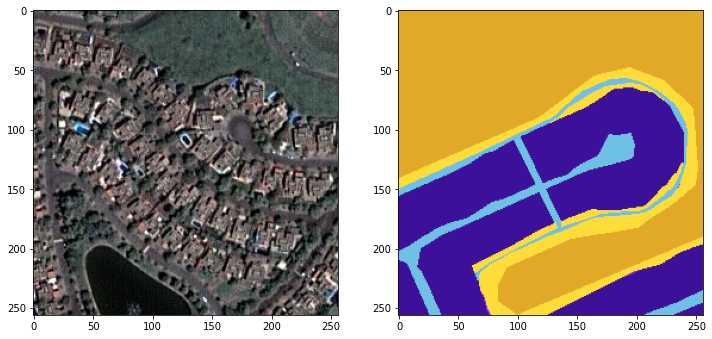

		Original Image 				Original Masks


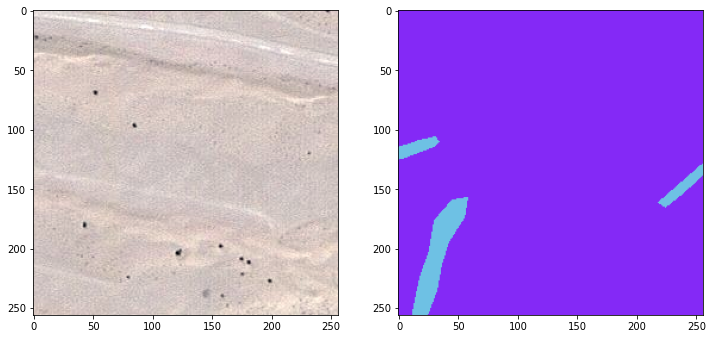

		Original Image 				Original Masks


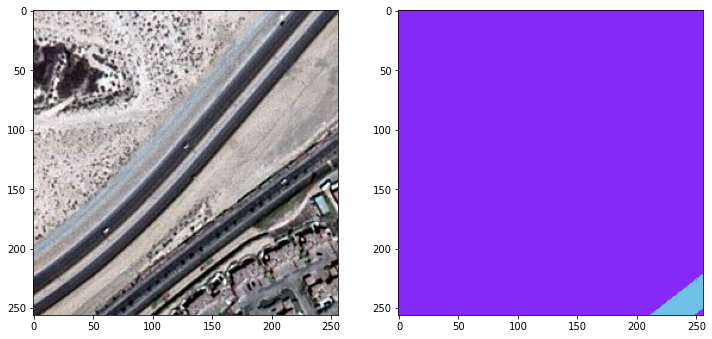

		Original Image 				Original Masks


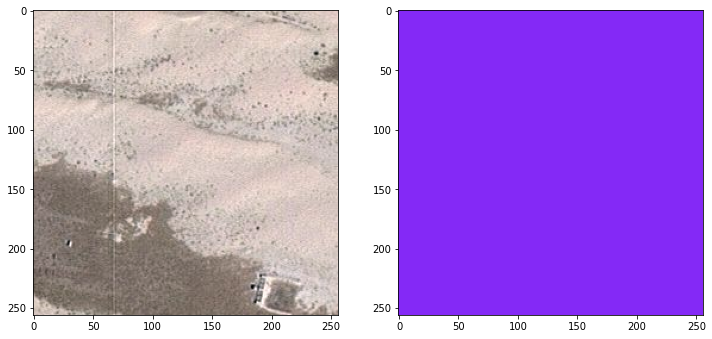

		Original Image 				Original Masks


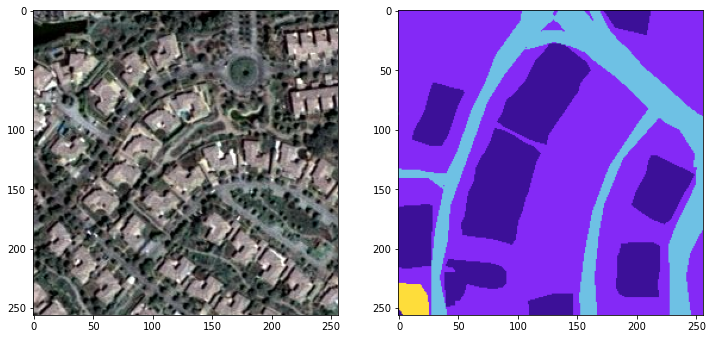

		Original Image 				Original Masks


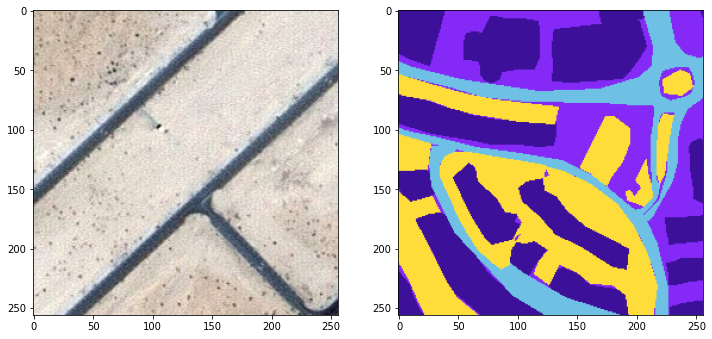

		Original Image 				Original Masks


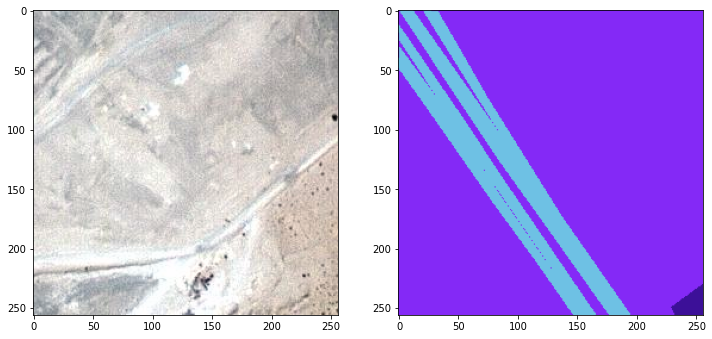

		Original Image 				Original Masks


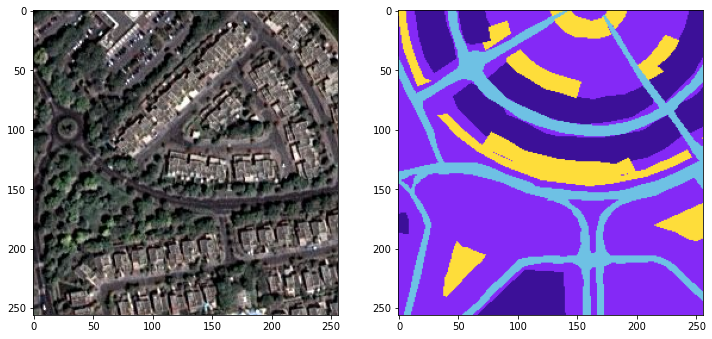

In [24]:
#Showing Original Images and There Masks
for i in range (10):
  image_number = random.randint(0, len(image_dataset))
  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  print("\t\tOriginal Image \t\t\t\tOriginal Masks")
  plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
  plt.subplot(122)
  plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
  plt.show()

In [25]:
def augmentFunc(width, height):
    transform = A.Compose([
        A.RandomCrop(width=width, height=height, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.OneOf([
            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
        ], p=1.0),
    ], p=1.0)
    
    return transform

In [26]:
def dataVisualize(image, mask, original_image=None, original_mask=None):
    fontsize = 16

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(10, 10), squeeze=True)
        f.set_tight_layout(h_pad=5, w_pad=5)

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 12), squeeze=True)
        plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=0.01)

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original Image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original Mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
    plt.savefig('sample_augmented_image.png', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)

In [27]:
import json
from unittest.mock import patch
import pytest
import albumentations.augmentations.functional as F
import albumentations.augmentations.geometric.functional as FGeometric
from albumentations.core.serialization import SERIALIZABLE_REGISTRY, shorten_class_name
from albumentations.core.transforms_interface import ImageOnlyTransform

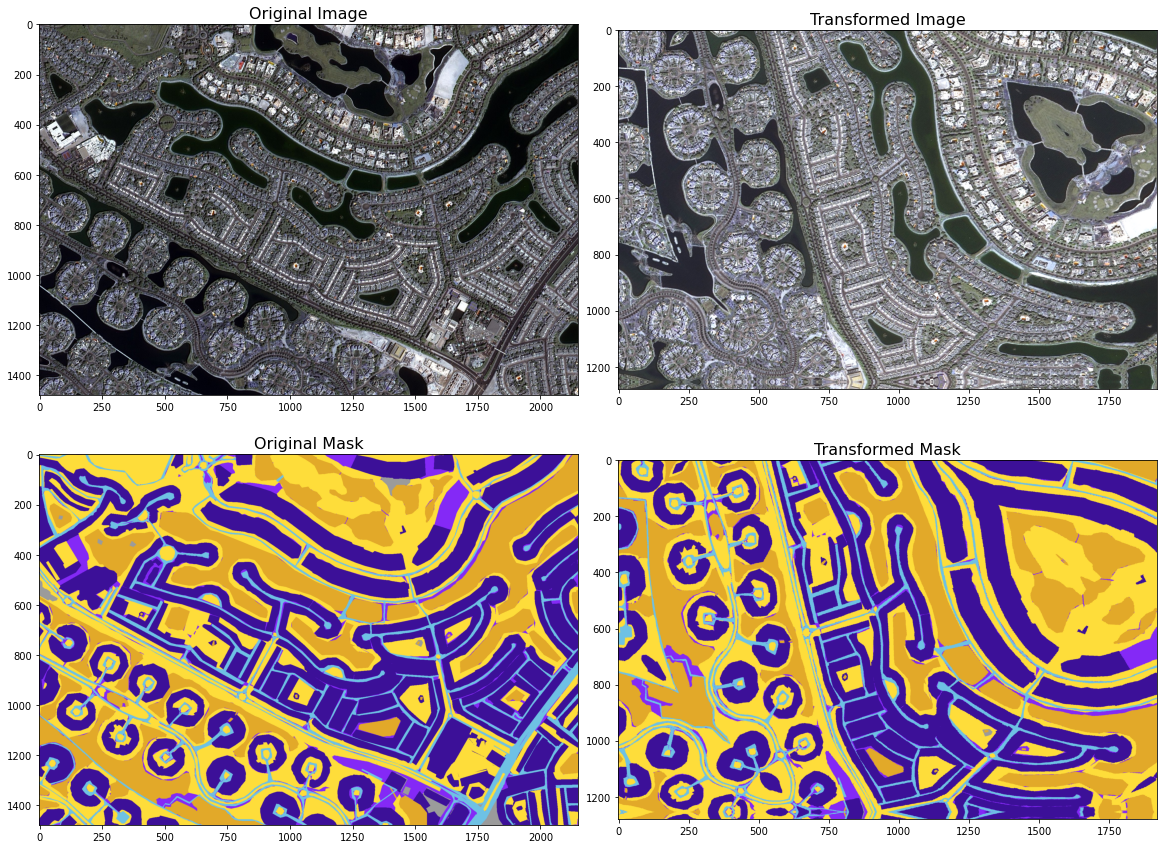

In [28]:
image = cv2.imread("/content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images/image_part_007.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread("/content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_007.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
transform = augmentFunc(1920, 1280)
transformed = transform(image=image, mask=mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']
cv2.imwrite('./image.png',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
cv2.imwrite('./mask.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))
dataVisualize(transformed_image, transformed_mask, image, mask)

In [29]:

###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152
"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

60
Unique labels in label dataset are:  [0 1 2 3 4 5]


In [30]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [31]:
# Training Model 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [32]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [33]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [34]:
IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS

(256, 256, 3)

In [35]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [36]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [37]:
metrics=['accuracy', jacard_coef]

In [38]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [39]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [41]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
66/66 [==============================] - 11s 164ms/step - loss: 1.0046 - accuracy: 0.5344 - jacard_coef: 0.1917 - val_loss: 1.0062 - val_accuracy: 0.5157 - val_jacard_coef: 0.1733
Epoch 2/100
66/66 [==============================] - 11s 164ms/step - loss: 1.0041 - accuracy: 0.5343 - jacard_coef: 0.1927 - val_loss: 1.0066 - val_accuracy: 0.5145 - val_jacard_coef: 0.1749
Epoch 3/100
66/66 [==============================] - 11s 165ms/step - loss: 1.0038 - accuracy: 0.5372 - jacard_coef: 0.1942 - val_loss: 1.0046 - val_accuracy: 0.5244 - val_jacard_coef: 0.1792
Epoch 4/100
66/66 [==============================] - 11s 165ms/step - loss: 1.0023 - accuracy: 0.5410 - jacard_coef: 0.1994 - val_loss: 1.0082 - val_accuracy: 0.4845 - val_jacard_coef: 0.1731
Epoch 5/100
66/66 [==============================] - 11s 166ms/step - loss: 1.0026 - accuracy: 0.5361 - jacard_coef: 0.1978 - val_loss: 1.0027 - val_accuracy: 0.5317 - val_jacard_coef: 0.1877
Epoch 6/100
66/66 [=====================

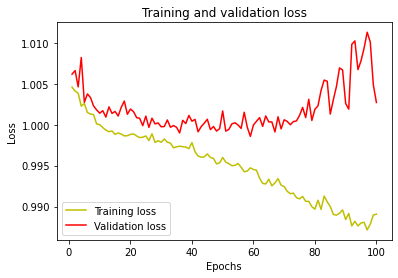

In [42]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

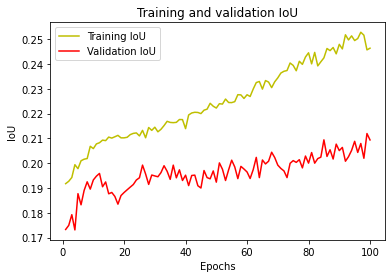

In [43]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [44]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


In [45]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.13874234


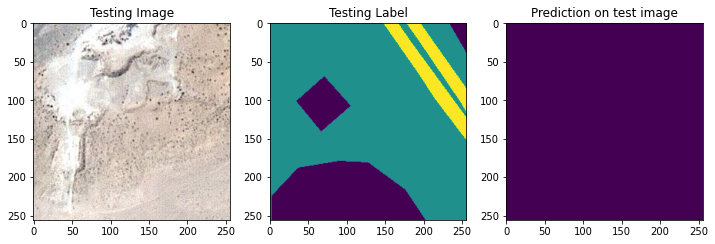

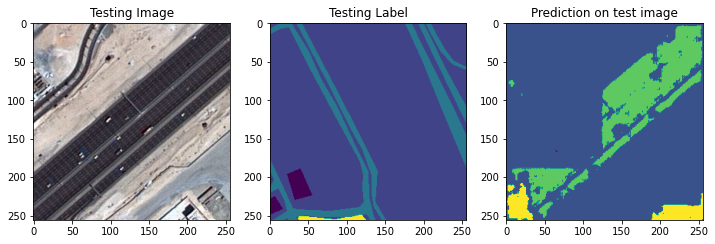

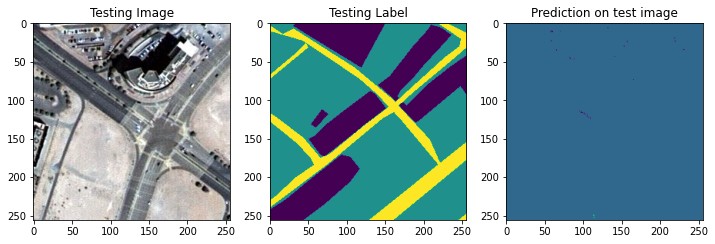

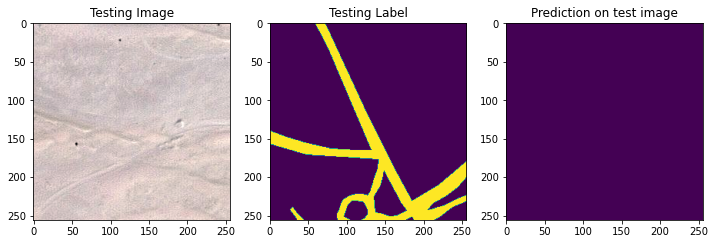

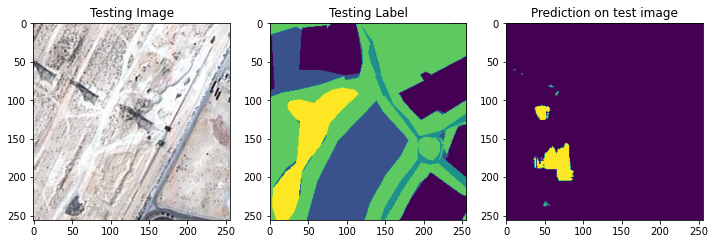

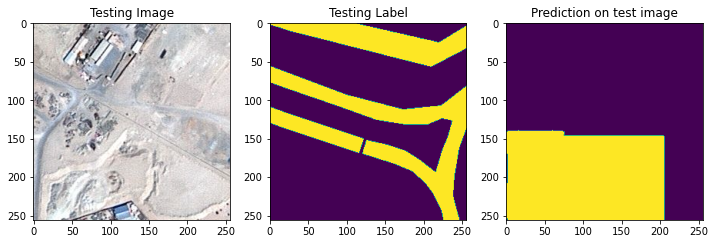

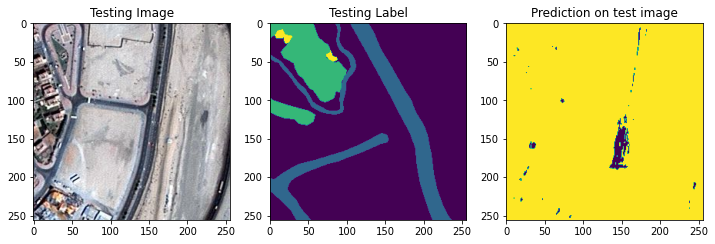

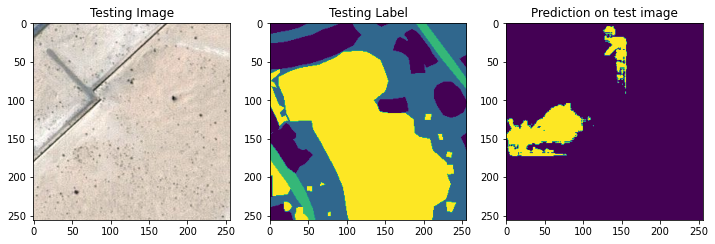

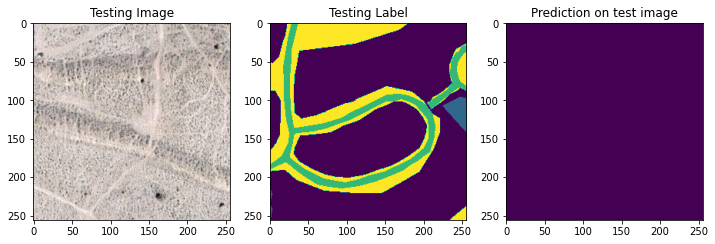

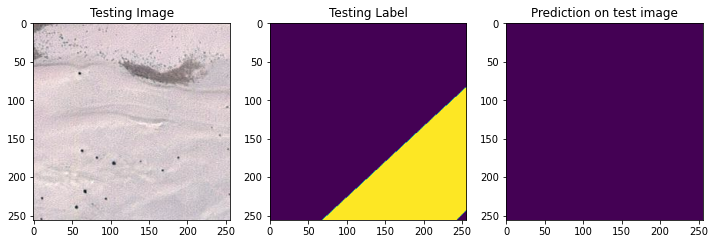

In [46]:
for i in range (10):
  test_img_number = random.randint(0, len(X_test))
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]

  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.show()